# Markov Decision Process in a Grid World

#### Goal: Reach a Specific Cell

Using the concepts of Markov Decision Process, we will find the optimal state values and policies (best actions) to the specific goal

### Pre-steps. Importing Required Libraries
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Step 1. Defining the MDP Components
---
**MDP Components**
- **Description**: A Markov Decision Process is a tuple $(\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \gamma)$
- **States ($\mathcal{S}$)**:
    - Each cell in the grid is a **state**.
    - For this world, it will be a 5x5 Grid with 25 states labeled as (0,0), (0,1), (1,2)...(4,4)
- **Actions ($\mathcal{A}$)**:
    - The agent can choose from: Up, Down, Left, Right.
- **Transition Probabilities ($\mathcal{P}$)**:
    - For simplicity, we will use **deterministic transitions** (i.e., when the agent chooses “Up,” it always moves up unless blocked by a wall).
- **Reward Function ($\mathcal{R}$)**:
    - Goal State: +1 Reward
    - Every Move: Small Negative reward (e.g. -0.1) to encourage efficiency.
- **Discount Factor $\gamma$**:
    - Discount will be $\gamma$ = 0.9, meaning the agent values future rewards slightly less than immediate ones.

In [2]:
# Defining the Grid Environment

grid_size = (5, 5)
states = [(i, j) for i in range(grid_size[0]) for j in range(grid_size[1])] # Initializing the states
actions = ['U', 'D', 'L', 'R'] # Up, Down, Left, Right
terminal_states = [(0, 0), (4, 4)] # Top-left, Top Right

def is_terminal(state):
    return state in terminal_states

# Transition Probabilities, Deterministic (Not Random)
def transition(state, action):
    # Returns the same state if its at the terminal state i.e. the end goal
    if is_terminal(state):
        return state
    i, j = state
    if action == 'U':
        # row: max(i - 1, 0) decreases the row index by 1, but makes sure it doesnt go below 0
        # col: stays the same
        return (max(i - 1, 0), j)
    if action == 'D':
        # row: min(i + 1, grid_size[0] - 1) increases the row index by 1, but makes 
        #      sure it doesn't go beyond the last index of the column (4 in this case)
        # col: stays the same
        return (min(i + 1, grid_size[0] - 1), j)
    if action == 'L':
        # row: stays the same
        # col: max(j - 1, 0) decreases the column index by 1, but makes sure it doesnt go below 0
        return (i, max(j - 1, 0))
    if action == 'R':
        # row: stays the same
        # col: min(j + 1, grid_size[1] - 1) increases the column index by 1, but makes 
        #      sure it doesn't go beyond the last index of the row (4 in this case)
        return (i, min(j + 1, grid_size[1] - 1))

# Reward Function
def reward(state, action):
    return -0.1 if not is_terminal(state) else 0

# Parameters
gamma = 0.9
theta = 0.0001 # Convergence Threshold

### Step 2. Initializing the State-Value Function (V)
---

The State-Value Function $v(s)$ estimates how good it is to be a in a certain state.

At first, we will be initializing the state-value of all states to $0$ i.e. This represents the agent having **no knowledge** about the environment yet.

In [3]:
# Initializing the Value Function
V = {state: 0 for state in states}

### Step 3. Applying the Bellman Equation
---

The goal is to find the optimal policy (best action for each state) by maximizing expected rewards. This is done through Dynamic Programming techniques:

#### Finding the Optimal Value Function $v_*(s)$

The Bellman Optimality Equation:

\begin{equation}
v_*(s)=\underset{a}{max}
\begin{bmatrix}
\mathcal{R}^a_s+\gamma \underset{s' \in S}{\sum} \mathcal{P}^a_{ss'} v_*(s')
\end{bmatrix}
\end{equation}

Since this environment is simply deterministic (no probability of changing actions), we will use the following equation:

\begin{equation}
v_*(s)=\underset{a}{max}
\begin{bmatrix}
\mathcal{R}^a_s+\gamma \cdot v_*(s')
\end{bmatrix}
\end{equation}

In [4]:
# 3.1 State-Value Iteration Loop
while True:
    delta = 0 # Used to store the changes in V(s)
    for state in states:

        # Do not compute if the state is a terminal state
        if is_terminal(state):
            continue

        v = V[state]

        V[state] = max( reward(state, action) + gamma * V[transition(state, action)] 
                        for action in actions
                      )
        delta = max(delta, abs(v - V[state]))

    # Stops the loop if delta is below the threshold (meaning, nothing changed that much)
    if delta < theta:
        break

#### Policy Extraction

After the value function stabilizes:

For each state, choose the action $a$ that maximizes the expected value. Again, the environment is deterministic thus, we will use the following equation:

\begin{equation}
\pi_*(s) = arg \text{ } \underset{a}{max} (\mathcal{R}^a_s + \gamma \cdot v_*(s'))
\end{equation}

In [5]:
# 3.2 Policy Extraction
policy = {}
for state in states:
    if is_terminal(state):
        policy[state] = 'T';
        continue

    best_action = max(actions, key=lambda action:
        reward(state, action) + gamma * V[transition(state, action)]
                     )
    policy[state] = best_action

### Step 4. Displaying the Results
---

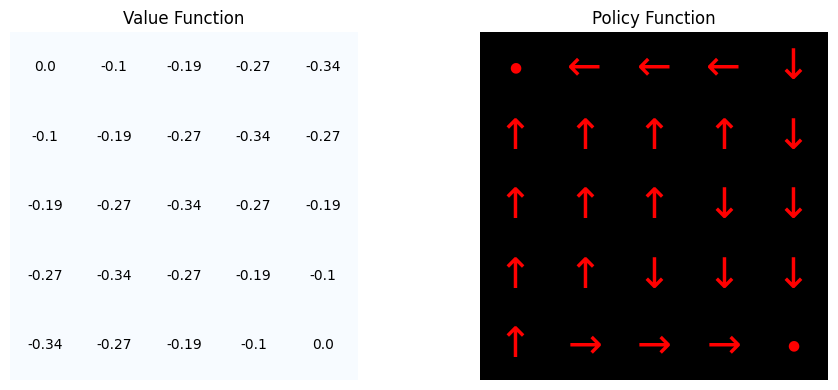

In [6]:
policy_mapping = {'T': 0, 'L': 1, 'D': 2, 'U': 3, 'R': 4}
policy_arrows = ["●", "←", "↓", "↑", "→"]

values = np.array([v for k, v in V.items()])
values = values.reshape(grid_size[0], grid_size[1])
policies = np.array([policy_mapping[v] for k, v in policy.items()])
policies = policies.reshape(grid_size[0], grid_size[1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Value Function
ax1 = axes[0]
ax1.imshow(np.zeros(grid_size), cmap='Blues', interpolation='none')
ax1.set_title('Value Function')
ax1.axis('off')
ax1.set_facecolor('white')

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        ax1.text(j, i, str(round(values[i][j], 2)), ha='center', va='center', color='black')

# Policy Function
ax2 = axes[1]
ax2.imshow(np.zeros(grid_size), cmap='gray', interpolation='none')
ax2.set_title('Policy Function')
ax2.axis('off')
ax2.set_facecolor('white')

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        ax2.text(j, i, str(policy_arrows[policies[i][j]]), size=(30 if not policies[i][j] == 0 else 'medium'), ha='center', va='center', color='red')

# Display the plot
plt.tight_layout()
plt.show()